# Chapter 3: Introducing Snorkel

In this chapter I will introduce [Snorkel](http://snorkel.org), which we'll use throughout the book. [Snorkel](https://www.snorkel.org/) is a software project ([github](https://github.com/snorkel-team/snorkel)) originally from the Hazy Research group at Stanford University enabling the practice of *weak supervision*, *distant supervision*, *data augmentation* and *data slicing*.

The project has an excellent [Get Started](https://www.snorkel.org/get-started/) page, and I recommend you spend some time working the [tutorials](https://github.com/snorkel-team/snorkel-tutorials) before proceeding beyond this chapter. 

Snorkel implements an unsupervised generative model that accepts a matrix of weak labels for records in your training data and produces strong labels by learning the relationships between these weak labels through matrix factorization.

In [144]:
import random
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import pyarrow

from lib import utils


# Make randomness reproducible
random.seed(31337)
np.random.seed(31337)

# Ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

## Example Project: Labeling Amazon Github Repositories

I have previously hand labeled about 2,600 Github repositories belonging to Amazon and its subsidiariesinto categories related to their purpose. We're going to use this dataset to introduce Snorkel.

### Hand Labeling this Data

In order to get a ground truth dataset against which to benchmark our Snorkel labeling, I hand labeled all Amazon Github projects in [this sheet](https://docs.google.com/spreadsheets/d/1wiesQSde5LwWV_vpMFQh24Lqx5Mr3VG7fk_e6yht0jU/edit?usp=sharing). The label categories are:

| Number | Code      | Description                          |
|--------|-----------|--------------------------------------|
| 0      | GENERAL   | A FOSS project of general utility    |
| 1      | API       | API library for AWS / Amazon product |
| 2      | RESEARCH  | A research paper and/or dataset      |
| 3      | DEAD      | Project is dead, no longer useful    |
| 3      | OTHER     | Uncertainty... what is this thing?   |

If you want to make corrections, please open the sheet, click on `File --> Make a Copy`, make any edits and then share the sheet with me.

In [145]:
# Show all columns to see the data menu :)
pd.options.display.max_columns = None

# Load the labeled data made up of Github API data and Github READMEs
df = pd.read_json('../data/amazon_github_repos.json.bz2', lines=True, compression='bz2')

# Trim the fields so we can see the data
df = df[[
    'id',
    'full_name',
    'description',
    'created_at',
    'updated_at',
    'homepage',
    'stargazers_count',
    'watchers',
    'forks',
    'open_issues',
    'license',
    'readme',
    'label'
]]

df['license'] = df['license'].apply(lambda x: x['name'] if x and 'name' in x else '')

# Remove empties to avoid spaCy processing errors
df = df.fillna('')

# Set the index to the project ID
df = df.set_index('id')

df.head()

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,The Alexa Skills Kit SDK for Node.js helps you...,2016-06-24 06:26:05,2020-02-21 22:20:59,,2811,2811,670,8,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API
84138837,alexa/alexa-cookbook,A series of sample code projects to be used fo...,2017-03-07 01:19:08,2020-02-23 04:01:25,,1557,1557,912,13,Other,\n# Alexa Skill Building Cookbook\n\n<div styl...,API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,1002,1002,1186,7,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https:/...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integra...,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,993,993,477,54,Apache License 2.0,### What is the Alexa Voice Service (AVS)?\n\n...,API
38904647,alexa/alexa-skills-kit-sdk-for-java,The Alexa Skills Kit SDK for Java helps you ge...,2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,715,715,720,2,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API


## Profile the Data

Let's take a quick look at the labels to see what we'll be classifying.

In [146]:
print(f'Total records: {len(df.index):,}')

df['label'].value_counts()

Total records: 2,568


API         2265
GENERAL      279
DEAD          14
RESEARCH       9
OTHER          1
Name: label, dtype: int64

### How much general utility do Amazon's Github projects have?

One question that occurs to me to ask is - how much general utility do Amazon's Github projects have? Let's look at the number of `GENERAL` purpose compared to the number of `API` projects.

In [147]:
api_count     = df[df['label'] == 'API'].count(axis='index')['full_name']
general_count = df[df['label'] == 'GENERAL'].count(axis='index')['full_name']

general_pct = 100 * (general_count / (api_count + general_count))
api_pct     = 100 * (api_count / (api_count + general_count))

print(f'Percentage of projects having general utility:   {general_pct:,.3f}%')
print(f'Percentage of projects for Amazon products/APIs: {api_pct:,.3f}%')

Percentage of projects having general utility:   10.967%
Percentage of projects for Amazon products/APIs: 89.033%


### Simplify to `API` vs `GENERAL`

We throw out `DEAD`, `RESEARCH` and `OTHER` to focus on `API` vs `GENERAL` - is an open source project of general utility or is it a client to a company's commercial products? Highly imabalanced classes are hard to deal with when building a classifier, and 1:9 for `GENERAL`:`API` is bad enough.

In [148]:
df = df[df['label'].isin(['API', 'GENERAL'])]

print(f'Total records with API/GENERAL labels: {len(df.index):,}')

df.head()

Total records with API/GENERAL labels: 2,544


,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,The Alexa Skills Kit SDK for Node.js helps you...,2016-06-24 06:26:05,2020-02-21 22:20:59,,2811,2811,670,8,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API
84138837,alexa/alexa-cookbook,A series of sample code projects to be used fo...,2017-03-07 01:19:08,2020-02-23 04:01:25,,1557,1557,912,13,Other,\n# Alexa Skill Building Cookbook\n\n<div styl...,API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,1002,1002,1186,7,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https:/...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integra...,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,993,993,477,54,Apache License 2.0,### What is the Alexa Voice Service (AVS)?\n\n...,API
38904647,alexa/alexa-skills-kit-sdk-for-java,The Alexa Skills Kit SDK for Java helps you ge...,2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,715,715,720,2,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API


### Split our Data into Training and Validation Data

In order to demonstrate Snorkel's capabilities, we need to create an experiment by splitting our data into three datasets:

* A hand labeled development dataset `dev_df` we will use to determine if our LFs work
* An unlabeled training dataset `train_df` that Snorkel's LabelModel will use to learn the labels
* A hand labeled test dataset `test_df` used to validate that the discriminative model we train with our labeled data works

The point of Snorkel is that you don't need labels - so we won't be using labels with the training dataset, `train_df`. Therefore we delete that variable to keep ourselves honest :) We also keep the development dataset `dev_df` small to demonstrate that you only need to label a small amount of representative data.

Once we've prepared our three dataset splits, because the labeled dev dataset `dev_df` is small, we run a value count for each of its labels to verify we have an adequate number of each label. It looks like we have around ten, which will do. People use Snorkel without any labels at all but at least ten of each label is very helpful in evaluating the performance, as we code, of the data programs we'll be writing to label data/

In [386]:
from sklearn.model_selection import train_test_split

# First split into a dev/train dataset we'll split next and a test dataset for our final model
dev_train_df, test_df, train_labels, test_labels = train_test_split(
    df,
    df['label'],
    test_size=0.75
)

# Then split the dev/train data to create a small labeled dev dataset and a larger unlabeled training dataset
dev_df, train_df, dev_labels, train_labels = train_test_split(
    dev_train_df,
    dev_train_df['label'],
    test_size=0.65
)

# Make sure our split of records makes sense
print(f'Total dev records:   {len(dev_df.index):,}')
print(f'Total train records: {len(train_df.index):,}')
print(f'Total test records:  {len(test_df.index):,}')

# Remove the training data labels - normally we would not have labeled these yet - this is why we're using Snorkel!
del train_labels

# Count labels in the dev set
dev_labels.value_counts(), test_labels.value_counts()

Total dev records:   222
Total train records: 414
Total test records:  1,908


(API        198
 GENERAL     24
 Name: label, dtype: int64, API        1709
 GENERAL     199
 Name: label, dtype: int64)

## Working with Snorkel

Snorkel has three primary programming interfaces: Labeling Functions, Transformation Functions and Slicing Functions.

<img 
     alt="Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions"
     src="images/snorkel_apis_0.9.5.png"
     width="500px"
/>
<div align="center">Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions, from <a href="https://www.snorkel.org/">Snorkel.org</a></div>

### Labeling Functions (LFs)

A labeling function is a deterministic function used to label data as belonging to one class or another. They produce weak labels that in combination, through Snorkel’s generative models, can be used to generate strong labels for unlabeled data.

The [Snorkel paper](https://arxiv.org/pdf/1711.10160.pdf) explains that LFs are open ended, that is that they can leverage information from multiple sources - both inside and outside the record. For example LFs can operate over different parts of the input document, working with document metadata, entire texts, individual paragraphs, sentences or words, parts of speech, named entities extracted by preprocessors, text embeddings or any augmentation of the record whatsoever. They can simultaneously leverage external databases and rules through *distant supervision*. These might include vocabulary for keyword searches, heuristics defined by theoretical considerations or equations, 

For example, a preprocessor might run a text document through a language model such as the included `SpacyPreprocessor` to run Named Entity Resolution (NER) and then look for words queried from WikiData that correspond to a given class. There are many ways to write LFs. We’ll define a broad taxonomy and then demonstrate some techniques from each.

The program interface for Labeling Functions is [`snorkel.labeling.LabelingFunction`](https://snorkel.readthedocs.io/en/v0.9.5/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction). They are instantiated with a name, a function reference, any resources the function needs and a list of any preprocessors to run on the data records before the labeling function runs.

<img alt="LabelingFunction API" src="images/labeling_function_api.png" width="600" />

### Defining Labeling Schema

In order to write our first labeling function, we need to define the label schema for our problem. The first label in any labeling schema is `-1` for `ABSTAIN`, which means "cast no vote" about the class of the record. This allows Snorkel Labeling Functions to vote only when they are certain, and is critical to how the system works since labeling functions have to perform better than random when they do vote or the Label Model won't work well.

The labels for this analysis are:

| Number | Code      | Description                       |
|--------|-----------|-----------------------------------|
| -1     | ABSTAIN   | No vote, for Labeling Functions   |
| 0      | GENERAL   | A FOSS project of general appeal  |
| 1      | API       | An API library for AWS            |

In [387]:
# Define our numeric labels as integers
ABSTAIN = -1
GENERAL = 0
API     = 1


def map_labels(x):
    """Map string labels to integers"""
    if x == 'API':
        return API
    if x == 'GENERAL':
        return GENERAL


dev_labels    =   dev_labels.apply(map_labels, convert_dtype=True)
test_labels   =  test_labels.apply(map_labels, convert_dtype=True)

dev_labels.shape, test_labels.shape

((222,), (1908,))

In [388]:
# Help map back and forth between strings and integer labels
label_pairs = [
    (ABSTAIN, 'ABSTAIN'),
    (GENERAL, 'GENERAL'),
    (API, 'API'),
]

# Forward and reverse indexes to labels/names
number_to_name_dict = dict(label_pairs)
name_to_number_dict = dict([(x[1],x[0]) for x in label_pairs])

### Writing our First Labeling Function

In order to write a labeling function, we must describe our data to associate a property with a certain class of records that can be programmed as a heuristic. Let's inspect some of our records. The classes are imbalanced 9:1, so lets pull a stratified sample of both labels.

Look at the data table produced by the records below and try to eyeball any patterns among the `API` and the `GENERAL` records. Do you see any markers for `API` records or `GENERAL` records?

In [389]:
# Set Pandas to display more than 10 rows
pd.set_option('display.max_rows', 100)

api_df     = dev_df[dev_df['label'] ==     'API'].sample(frac=1).head(20).sort_values(by='label')
general_df = dev_df[dev_df['label'] == 'GENERAL'].sample(frac=1).head(10).sort_values(by='label')

api_df.append(general_df).head(30)

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
36331048,aws/aws-php-sns-message-validator,Amazon SNS message validation for PHP,2015-05-26 23:52:56,2020-02-23 18:41:48,,134,134,36,3,Apache License 2.0,"[![Build Status](https://travis-ci.org/aws/aws-xray-daemon.svg?branch=master)](https://travis-ci.org/aws/aws-xray-daemon)\n\n# AWS X-Ray Daemon \n\nThe AWS X-Ray daemon is a software application that listens for traffic on UDP port 2000, gathers raw segment data, and relays it to the AWS X-Ray ...",API
81595604,aws-samples/ecs-refarch-batch-processing,A reference architecture for handling batch processing workloads using Amazon ECS.,2017-02-10 18:43:15,2020-01-18 15:40:32,,97,97,33,6,Apache License 2.0,# AIM427-Take an ML from idea to production using Amazon SageMaker\n\n#### Use following url to sign in into an AWS Account. Use the hash provided as the login credential. \n\n```\nhttps://dashboard.eventengine.run/login\n```\n\n## Workshop Lab Guide\n\nAmazon SageMaker has built-in algorithms t...,API
63275493,alexa/skill-sample-nodejs-hello-world,,2016-07-13 19:59:17,2020-02-24 10:27:16,,155,155,258,4,Apache License 2.0,"# Build An Alexa Decision Tree Skill\n<img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/alexa/alexa-skills-kit/tutorials/fact/header._TTH_.png"" />\n\n\n# How to Build a Decision Tree skill for Alexa\n\n\n## What You Will Learn\n* [Alexa Skills Kit (ASK)](https://developer.amazon....",API
171725089,aws/aws-app-mesh-inject,AWS AppMesh sidecar injector for EKS.,2019-02-20 18:12:54,2020-02-12 22:02:11,,50,50,35,10,Apache License 2.0,git-remote-codecommit\n=====================\n\nThis package provides a simple method for pushing and pulling from `AWS\nCodeCommit <https://aws.amazon.com/codecommit/>`__. This package extends `git\n<https://git-scm.com/>`__ to support repository urls prefixed with\n**codecommit://** by impleme...,API
165183120,aws-samples/dms-cloudformation-templates-generator,Sample code that reads Microsoft Excel workbook/CSV File for the details required to create a DMS task CloudFormation template,2019-01-11 05:11:53,2019-12-20 11:52:39,,7,7,7,0,Other,"## AWS CI/CD simple Node.js app\n\nThe purpose of this demo is show how to use some AWS services for CI/CD. We have a Node.js application utilizing Amazon Rekognition API to identify celebrities and we are going to automatize the source, build and deploy process.\n\n\n![demo](cicd.jpg)\n\nTo get...",API
113228427,amazon-archives/amazon-mcf-plugin-for-magento-2,Plugin code to enable Amazon MCF in Magento 2.,2017-12-05 20:15:25,2019-08-22 07:10:06,,9,9,3,11,Apache License 2.0,"= Kubernetes the AWSome Way!\n:icons:\n:linkattrs:\n:imagesdir: resources/images\n\nimage:kubernetes-aws-smile.png[alt=""kubernetes and aws logos"", align=""left"",width=420]\n\nThis is a self-paced workshop designed for Development and Operations teams who would like to leverage Kubernetes on Amazo...",API
40509314,awslabs/ec2-spot-labs,Collection of tools and code examples to demonstrate best practices in using Amazon EC2 Spot Instances.,2015-08-10 22:32:53,2020-02-23 19:33:07,https://aws.amazon.com/ec2/spot/,602,602,207,7,Other,"# aws-security-automation\nCollection of scripts and resources for DevSecOps, Security Automation and Automated Incident Response Remediation\n\n## IAM Access Denied Responder\n\nThis example solution will setup an automated response to an access denied event that occurs within a CloudTrail even...",API
127472365,aws/amazon-neptune-sparql-java-sigv4,A SPARQL client for Amazon Neptune that includes AWS Signature Version 4 signing. Implemented as an RDF4J repository.,2018-03-30 20:56:50,2019-04-23 21:34:12,,6,6,5,0,Apache License 2.0,# meta-aws\n\nThe **meta-aws** project provides *recipes* for building in AWS edge software capabilities to [Embedded Linux](https://elinux.org) built with [OpenEmbedded](https://www.openembedded.org) and [Yocto Project](h

### Detecting Patterns

In looking at the `full_name` and `html_url`, it looks like projects with `sdk` in the title are `API` projects. Lets filter down to those records to see.

In [390]:
sdk_df = dev_df[dev_df['full_name'].str.contains('sdk')]

print(f'Total SDK records: {len(sdk_df.index)}')

sdk_df.groupby('label').count()['full_name']

Total SDK records: 13


label
API        12
GENERAL     1
Name: full_name, dtype: int64

## Building an SDK Labeling Function

There is an 8:0 `API`:`GENERAL` ratio of labels among records with `sdk` in their full_name. This is more than good enough for a Labeling Function (LF), since they only have to be better than random! Cool, eh? Don't worry, the `LabelModel` will figure out which signal from which LF to use :) It's like magic!

This is called a keyword labeling function, the simplest type. Despite their simplicity, keyword LFs are incredibly powerful ways to inject subject matter expertise into a project. In the chapter on Weak Supervision, we'll get into the various types of LFs and the strategies researchers and Snorkel users have come up with for labeling data. For now we'll create this and a couple of other LFs and see where that gets us.

In [391]:
# The verbosse way to define an LF
from snorkel.labeling import LabelingFunction


sdk_lf = LabelingFunction(
    name="name_contains_sdk_lf",
    f=lambda x: API if 'sdk' in x.full_name.lower() else ABSTAIN,
)

print(sdk_lf)


# The short form way to define an LF
from snorkel.labeling import labeling_function


@labeling_function()
def name_contains_sdk_lf(x):
    return API if 'sdk' in x.full_name.lower() else ABSTAIN

print(sdk_lf)

LabelingFunction name_contains_sdk_lf, Preprocessors: []
LabelingFunction name_contains_sdk_lf, Preprocessors: []


## Testing our `LabelingFunction`

Snorkel comes with tools to help you run your LFs on your dataset to see how they perform. We're using Pandas, so we use [`snorkel.labeling.PandasLFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html) to apply our list of label functions (in this case just one) to the hand-labeled development dataset `dev_df` and the unlabeled training dataset `train_df`. Note that there are also `LFAppliers` for [Dask](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.dask.DaskLFApplier.html) and [PySpark](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.spark.SparkLFApplier.html#snorkel.labeling.apply.spark.SparkLFApplier).

In [392]:
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier


lfs = [sdk_lf]

# Instantiate our LF applier with our list of LabelFunctions (just one for now)
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 28803.88it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.058559,0.0,0.0,12,1,0.923077


In [393]:
# Run the same LF analysis on the unlabeled training data, accuracy yet unknown
LFAnalysis(L=L_train,  lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.041063,0.0,0.0


## Interpreting the `LFAnalysis` Summary

Looking at the tables above coverage of our first LF is about 7.6%, which means that it abstains by voting `ABSTAIN`/`-1` 92.4% of the time. In practice we need enough `LabelingFunctions` to cover more of the data than this and we must also write at least one LF per unique tag. Now that we've got an LF for `API`, let's write one for `GENERAL`.

## Writing Another `LabelingFunction`

We need more than just one vote to accurately label our data, so now we're going to inspect the data again and arrive at several more LFs - data programs - to label the data as either `API` or `GENERAL`.

### Inspecting the Development Data

To begin, let's write a function to perform the operation we did above to create a DataFrame showing a mix of `API` and `GENERAL` labels to get a sense of the difference between them. This is the point at which we are injection domain expertise as a form of supervision. Convenient this is about software, as we are the domain experts :)

In [394]:
def stratified_sample(a_df, b_df, labels, n=[20, 10]):
    """Given two pd.DataFrames, their labels and desired ratios, acreate a stratified sample and display n records"""
    a_sample_df = a_df[a_df['label'] == labels[0]].sample(frac=1).head(n[0]).sort_values(by='label')
    b_sample_df = b_df[b_df['label'] == labels[1]].sample(frac=1).head(n[1]).sort_values(by='label')

    return a_df.append(b_df).sample(frac=1.0).head(sum(n))


stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
43976345,amzn/ion-tests,Test vectors for testing compliant Ion implementations.,2015-10-09 19:38:10,2020-01-28 22:39:11,,23,23,13,7,Apache License 2.0,## Zeek Plugin ENIP\n\nWhen running as part of your Zeek installation this plugin will produce three log files containing metadata extracted from any Ethernet/IP (ENIP) and Common Industrial Protocol (CIP) traffic observed on UDP port 2222 and port 44818 TCP/UDP. Ethernet/IP and CIP are often ob...,GENERAL
202016782,aws-samples/aws-appsync-visualization-with-athena-app,Custom visualization with AWS AppSync using Amazon Athena as a data source. Built with AWS Amplify CLI.,2019-08-12 22:12:08,2020-02-23 01:01:15,,14,14,24,4,Other,"# aws-sdk-js-v3-workshop\n\nIn this workshop, we're going to:\n\n- Build a simple note taking application\n- Identify the benefits of using AWS JS SDK v3 over v2\n\nThe note taking application is the modified version from the original Open Source MIT licensed project shared in the tutorials on [...",API
66405970,cloud9ide/livereload-example,Cloud9 Grunt livereload with static files + sass,2016-08-23 21:49:15,2019-10-16 16:58:44,,3,3,2,2,MIT License,# vod-samples\nThis repository contains samples illustrating how to use VOD related API calls on Twitch.\n\n1. [Python](https://github.com/TwitchDev/vod-samples/tree/master/python) - A simple Python command-line application to copy VOD's from YouTube to Twitch.\n,GENERAL
63275493,alexa/skill-sample-nodejs-hello-world,,2016-07-13 19:59:17,2020-02-24 10:27:16,,155,155,258,4,Apache License 2.0,"# Build An Alexa Decision Tree Skill\n<img src=""https://m.media-amazon.com/images/G/01/mobile-apps/dex/alexa/alexa-skills-kit/tutorials/fact/header._TTH_.png"" />\n\n\n# How to Build a Decision Tree skill for Alexa\n\n\n## What You Will Learn\n* [Alexa Skills Kit (ASK)](https://developer.amazon....",API
78153001,awslabs/samljs-serverless-sample,"Sample Lambda code, CloudFormation, SAM templates and Client website for performing SAML auth flows for AWS access in user applications",2017-01-05 22:22:16,2020-02-21 22:01:42,,88,88,33,1,Other,"## IoT Device Simulator\nIoT is a sprawling set of technologies and use cases that has no clear, single definition. Despite enormous advances, we’ve only seen a fraction of what the Internet revolution has yet to deliver. That’s because many powerful technological forces are now converging — poi...",API
212657288,aws-samples/aws-braziltechtalk2019-aiservices-demo,AWS AI Services demo to show how you can use AWS AI services APIs. Showed at AI/ML Brazil workshop: source code and materials.,2019-10-03 19:03:38,2019-10-23 21:38:41,,2,2,3,0,Other,## Serverless Machine Learning On AWS\n\nThe ```template.json``` file is an AWS CloudFormation template that builds the following serverless components:\n\n* An [AWS CodeBuild](https://aws.amazon.com/codebuild/) project based on the ```buildspec.yaml``` file that creates AWS Lambda Layers that c...,API
112677679,aws-samples/aws-rekognition-lex-demo,Demonstrates how to use AWS Lex to control/use AWS Rekognition.,2017-12-01 00:54:40,2018-10-11 22:38:53,,4,4,2,2,Apache License 2.0,# AWS Big Data Blog - Create an Amazon Redshift Data Warehouse That Can Be Securely Accessed Across Accounts\n\nThis code demonstrates the steps outlined on the AWS big data blog (https://aws.amazon.com/blogs/big-data/create-an-amazon-redshift-data-warehouse-that-can-be-securely-accessed-across-...,API
59868262,aws/chalice,Python Serverless Microframework for AWS,2016-05-27 23:27:13,2020-02-24 22:52:02,,6468,6468,659,269,Apache License 2.0,# AWS SDK for Ruby - Version 3\n\n[![Gitter](https://badges.gitter.im/aws/aws-sdk-ruby.svg)](https://gitter.im/aws/aws-sdk-ruby?utm_source=badge&utm_medium=badge&utm_campaign=pr-badge) [![Build Status](https://travis-ci.org/aws/aws-sdk-ruby.svg?branch=master)](https://travis-ci.org/aws/aws-sdk-r...,API
12747236

### Creating an Ion `LabelingFunction`

I notice that there are two projects labeled `GENERAL` that have the word "ion" in their project name. I happen to know that Ion is Amazon's storage format for complex data, and that it is a project with general utility. 

#### Investingating the "ion"/`GENERAL` Pattern

Let's investigate and if it pans out we'll write another LF. 

In [395]:
dev_df[dev_df['full_name'].str.contains('ion')]

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
98933308,awslabs/aws-encryption-sdk-test-vectors,Test vectors for the AWS Encryption SDK,2017-07-31 21:56:32,2019-07-31 13:02:48,,4,4,6,2,Apache License 2.0,## AWS Common Runtime for .NET\n\n.NET bindings for the AWS Common Runtime\n\n## License\n\nThis library is licensed under the Apache 2.0 License. \n,API
222004116,awslabs/predictive-segmentation-using-amazon-pinpoint-and-amazon-sagemaker,,2019-11-15 21:13:28,2020-01-23 16:00:51,,2,2,1,0,Apache License 2.0,## cloud-templates-ruby-graphviz\n\nGraphViz render for cloud-templates-ruby. Generates visual representation for arbitrary model.\n\n## License\n\nThis library is licensed under the Apache 2.0 License. \n,API
122409283,awsdocs/aws-step-functions-developer-guide,The open source version of the AWS Step Functions Developer Guide. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.,2018-02-22 00:00:09,2020-02-03 07:01:19,,60,60,48,10,Other,## AWS Cost Management User Guide\n\nThe open source version of the AWS Billing and Cost Management docs. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.\n\n## License Summary\n\nThe documentation is made...,API
165183120,aws-samples/dms-cloudformation-templates-generator,Sample code that reads Microsoft Excel workbook/CSV File for the details required to create a DMS task CloudFormation template,2019-01-11 05:11:53,2019-12-20 11:52:39,,7,7,7,0,Other,"## AWS CI/CD simple Node.js app\n\nThe purpose of this demo is show how to use some AWS services for CI/CD. We have a Node.js application utilizing Amazon Rekognition API to identify celebrities and we are going to automatize the source, build and deploy process.\n\n\n![demo](cicd.jpg)\n\nTo get...",API
43976345,amzn/ion-tests,Test vectors for testing compliant Ion implementations.,2015-10-09 19:38:10,2020-01-28 22:39:11,,23,23,13,7,Apache License 2.0,## Zeek Plugin ENIP\n\nWhen running as part of your Zeek installation this plugin will produce three log files containing metadata extracted from any Ethernet/IP (ENIP) and Common Industrial Protocol (CIP) traffic observed on UDP port 2222 and port 44818 TCP/UDP. Ethernet/IP and CIP are often ob...,GENERAL
194744087,aws-samples/amazon-eks-refarch-cloudformation,Reference architecture of Amazon EKS cloudformation templates and AWS CDK samples,2019-07-01 21:16:52,2020-02-13 15:52:47,,40,40,23,2,Other,"## AWS IoT Just In Time Provisioning Sample Scripts\n\nThese are sample scripts for demonstrating how to use a custom CA and Just In \nTime Provisioning (JITP) with AWS IoT at scale.\n\nThese scripts are not meant for production use, but are meant to help explain \nthe steps involved in generati...",API
162644504,aws-cloudformation/cloudformation-cli-python-plugin,The CloudFormation Provider Development Toolkit Python Plugin allows you to autogenerate Python code based on an input schema.,2018-12-21 00:13:18,2020-01-31 22:04:04,,24,24,7,16,Apache License 2.0,,API
202016782,aws-samples/aws-appsync-visualization-with-athena-app,Custom visualization with AWS AppSync using Amazon Athena as a data source. Built with AWS Amplify CLI.,2019-08-12 22:12:08,2020-02-23 01:01:15,,14,14,24,4,Other,"# aws-sdk-js-v3-workshop\n\nIn this workshop, we're going to:\n\n- Build a simple note taking application\n- Identify the benefits of using AWS JS SDK v3 over v2\n\nThe note taking application is the modified version from the original Open Source MIT licensed project shared in the tutorials on [...",API
26242560,awslabs/dynamodb-cross-region-library,A library to facilitate cross-region replication with Amazon DynamoDB Streams.,2014-11-05 22:25:41,2020-02-04 02:36:40,,256,256,91,13,Apache License 2.0,# Data Lake Solution\n\nMany Amazon Web Services (AWS) custom

#### Iterating on our Pattern

Ah, it looks like "ion" isn't good enough, as it is picking up lots of other words with "ion" in them. Lets try "/ion" since the examples we can see have that pattern"

In [396]:
dev_df[dev_df['full_name'].str.contains('/ion')]

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
43976345,amzn/ion-tests,Test vectors for testing compliant Ion implementations.,2015-10-09 19:38:10,2020-01-28 22:39:11,,23,23,13,7,Apache License 2.0,## Zeek Plugin ENIP\n\nWhen running as part of your Zeek installation this plugin will produce three log files containing metadata extracted from any Ethernet/IP (ENIP) and Common Industrial Protocol (CIP) traffic observed on UDP port 2222 and port 44818 TCP/UDP. Ethernet/IP and CIP are often ob...,GENERAL
234407137,amzn/ion-go,A Go implementation of Amazon Ion.,2020-01-16 20:37:16,2020-02-23 17:33:22,http://amzn.github.io/ion-docs/,2,2,2,19,Apache License 2.0,[![Maven Central](https://maven-badges.herokuapp.com/maven-central/software.amazon.pay/amazon-pay-sdk-v2-java/badge.svg)](https://maven-badges.herokuapp.com/maven-central/software.amazon.pay/amazon-pay-sdk-v2-java)\n\n### Amazon Pay Java V2 SDK\n\n### Requirements\n\n* Amazon Pay - [Register her...,GENERAL


Looks better! While 3:0 is not overwhelming support I happen to know there are many Ion projects and it is likely they mostly follow this pattern. Remember, `LabelingFunctions` don't have to be perfect - they just have to perform better than random. The magic of Snorkel's `LabelModel` is that it is unsupervised and models the interactions between LFs as a generative, graphical model it then uses to predict strong labels. When combined, these LFs give the model enough signal work do its job, turning multiple weak labels into one strong label.

### Writing the Ion Labeling Function

Now that we have the pattern, we can write another keyword LF.

In [397]:
@labeling_function()
def name_contains_slash_ion(x):
    return GENERAL if '/ion' in x.full_name.lower() else ABSTAIN


# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 16880.62it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.058559,0.0,0.0,12,1,0.923077
name_contains_slash_ion,1,[0],0.009009,0.0,0.0,2,0,1.000000


In [398]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.041063,0.0,0.0
name_contains_slash_ion,1,[0],0.012077,0.0,0.0


### Evaluating the LF Analysis

This LF works but has low coverage. We'll have to do better in terms of coverage if we're going to do a good job labeling `GENERAL` projects!

### Writing Another `LabelingFunction`

Again let's inspect the data and look what pops out.

In [399]:
stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
230346805,aws-samples/aws-appsync-refarch-microservices,,2019-12-27 00:41:37,2020-02-21 10:46:48,,12,12,6,0,Other,"## AWS Cloudformation Publisher\n\nAWS CloudFormation Publisher packages your CloudFormation templates into an S3 bucket in every AWS region and creates ""launch stack"" links that you can use in your documentation so that your customers can easily launch stacks in their AWS accounts from your Clo...",API
40509314,awslabs/ec2-spot-labs,Collection of tools and code examples to demonstrate best practices in using Amazon EC2 Spot Instances.,2015-08-10 22:32:53,2020-02-23 19:33:07,https://aws.amazon.com/ec2/spot/,602,602,207,7,Other,"# aws-security-automation\nCollection of scripts and resources for DevSecOps, Security Automation and Automated Incident Response Remediation\n\n## IAM Access Denied Responder\n\nThis example solution will setup an automated response to an access denied event that occurs within a CloudTrail even...",API
142940518,awslabs/aws-c-http,C99 implementation of the HTTP/1.1 and HTTP/2 specifications,2018-07-31 00:07:24,2020-02-13 21:48:15,,34,34,9,5,Apache License 2.0,# Amazon API Gateway Ingress Controller\n\n## Getting Started\n\nThe default configuration assumes you are using kube2iam to manage pod permissions.\nTo set up a role for this controller use the following command\n\n```sh\nexport INSTANCE_ROLE_ARNS=`comma delimited list of k8s worker instance AR...,GENERAL
66405970,cloud9ide/livereload-example,Cloud9 Grunt livereload with static files + sass,2016-08-23 21:49:15,2019-10-16 16:58:44,,3,3,2,2,MIT License,# vod-samples\nThis repository contains samples illustrating how to use VOD related API calls on Twitch.\n\n1. [Python](https://github.com/TwitchDev/vod-samples/tree/master/python) - A simple Python command-line application to copy VOD's from YouTube to Twitch.\n,GENERAL
113228427,amazon-archives/amazon-mcf-plugin-for-magento-2,Plugin code to enable Amazon MCF in Magento 2.,2017-12-05 20:15:25,2019-08-22 07:10:06,,9,9,3,11,Apache License 2.0,"= Kubernetes the AWSome Way!\n:icons:\n:linkattrs:\n:imagesdir: resources/images\n\nimage:kubernetes-aws-smile.png[alt=""kubernetes and aws logos"", align=""left"",width=420]\n\nThis is a self-paced workshop designed for Development and Operations teams who would like to leverage Kubernetes on Amazo...",API
30425378,c9/c9.ide.language.html,"The repository for c9.ide.language.html, a Cloud9 core plugin",2015-02-06 17:55:56,2019-08-13 16:02:27,https://c9.io/packages/c9.ide.language.html,3,3,4,1,Other,# c9.ide.language.generic\n,GENERAL
194744087,aws-samples/amazon-eks-refarch-cloudformation,Reference architecture of Amazon EKS cloudformation templates and AWS CDK samples,2019-07-01 21:16:52,2020-02-13 15:52:47,,40,40,23,2,Other,"## AWS IoT Just In Time Provisioning Sample Scripts\n\nThese are sample scripts for demonstrating how to use a custom CA and Just In \nTime Provisioning (JITP) with AWS IoT at scale.\n\nThese scripts are not meant for production use, but are meant to help explain \nthe steps involved in generati...",API
186068184,aws-samples/aws-xray-serverless-samples,Code samples showing the different ways to run AWS X-Ray in serverless applications,2019-05-10 23:59:02,2019-12-10 07:05:56,,9,9,3,0,Other,![SageCDKops](SagecdkOpsLogo.png)\n\n### Please note that this is a work in progress and meant for use with a ML specialist SA in a workshop setting.\n\n## Prerequisites\n\n### First install CDK\n\n```\nnpm install -g aws-cdk\n```\n\n### Install/Upgrade python SDK\n```\npip install --upgrade aws...,API
39536921,goodreads/generator-react-component,,2015-07-23 00:26:42,2019-08-15 17:15:02,,0,0,0,0,MIT License,"***NOTE: This project is no longer being updated publicly.***\n\n# Blueprint\n\nThe schema server for the\n[Twitch Science Data Pipeline](https://github.com/TwitchScience).\n\nSee also the [Schema Suggest

### Investigating Quick Start LFs

I see a pattern wherein proejct names with "quickstart" and project descriptions with "Quick Start" seem to be `API` projects. Let's see if we're right by isolating and inspecting these records and then counting the number of labels for this subset.

In [400]:
# First look for quickstart in the full name
quickstart_name_df = dev_df[dev_df['full_name'].str.contains('quickstart')]
quickstart_name_df

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
125287210,aws-quickstart/quickstart-mcafee-epo,AWS Quick Start Team,2018-03-14 23:36:58,2020-01-24 03:56:01,,5,5,10,4,Apache License 2.0,# quickstart-sios-protection-suite\n## SIOS Protection Suite for Linux on AWS\n\nThis Quick Start sets up an AWS architecture for SIOS Protection Suite for Linux and deploys it into your AWS account in a few easy steps.\n\nSIOS Protection Suite for Linux is a Linux clustering solution that provi...,API
201314831,aws-quickstart/quickstart-ibm-filenet-content-manager,AWS Quick Start Team,2019-08-08 18:25:32,2020-02-14 12:49:09,,2,2,2,0,Apache License 2.0,"# quickstart-dotnet-serverless-cicd\n## .NET Serverless CI/CD on the AWS Cloud\n\n.NET Framework is a managed execution environment for applications that provides memory management, class libraries, versioning, and other software development tools.\n\nThis Quick Start builds a .NET serverless CI...",API
167990991,aws-quickstart/quickstart-ibm-infosphere-datastage,AWS Quick Start Team,2019-01-28 16:04:40,2020-02-22 19:32:08,,10,10,5,0,Apache License 2.0,,API
71820039,aws-quickstart/quickstart-informatica-powercenter,AWS Quick Start Team,2016-10-24 18:39:23,2019-11-19 19:13:12,,2,2,7,1,Apache License 2.0,"# quickstart-tibco-jaspersoft\n## TIBCO JasperReports Server on the AWS Cloud\n\nThis Quick Start deploys TIBCO JasperReports Server, a reporting and analytics server, on the Amazon Web Services (AWS) Cloud in about 35 minutes. Options include the deployment of a cluster or of a single instance....",API
187261597,aws-quickstart/quickstart-nextflow,AWS Quick Start Team,2019-05-17 18:11:59,2020-02-21 05:29:08,,0,0,0,0,Apache License 2.0,# Node GNU tools\nGNU tools installer for npm\n,API
76398713,aws-quickstart/quickstart-symantec-protectionengine,AWS Quick Start Team,2016-12-13 21:11:46,2019-05-30 01:17:50,,1,1,4,0,Apache License 2.0,"# quickstart-nextflow\n## Nextflow on AWS – Biotech Blueprint\n\nThis Quick Start deploys a genomics analysis environment on the Amazon Web Services (AWS) Cloud, using Nextflow to create and orchestrate analysis workflows and AWS Batch to run the workflow processes.\n\nNextflow is an open-source...",API
58953768,aws-quickstart/quickstart-microsoft-servers,AWS Quick Start Team,2016-05-16 17:43:39,2019-05-30 01:17:38,,3,3,10,0,Apache License 2.0,# quickstart-deloitte-truevoice\n\n## TrueVoice Registration and Integration\n\nDeploying this Quick Start provides registration and proposed onboarding information for validation by the TrueVoice customer engagement team. After successful registration and due-diligence procedures are completed ...,API
198835594,aws-quickstart/quickstart-hitrust-csf,AWS Quick Start Team,2019-07-25 13:20:31,2020-02-17 10:39:24,,1,1,0,1,Apache License 2.0,# ![Logo](blox-logo.png)\n\n# Blox: Open Source schedulers for Amazon ECS\n\n[![Build Status](https://travis-ci.org/blox/blox.svg?branch=master)](https://travis-ci.org/blox/blox)\n\nBlox provides open source schedulers optimized for running applications on Amazon ECS. Developers now have greater...,API
138046962,aws-quickstart/quickstart-dynatrace,AWS Quick Start Team,2018-06-20 14:50:41,2020-01-29 18:46:24,,3,3,9,0,Apache License 2.0,# quickstart-symantec-protection-engine\n## Symantec Protection Engine on AWS\n\nUse this Quick Start to deploy Symantec Protection Engine (SPE) for Cloud Services on AWS in less than an hour.\n\nSPE enables you to incorporate malware and threat detection technologies into your application. SPE ...,API


In [401]:
quickstart_name_df['label'].value_counts()

API    9
Name: label, dtype: int64

In [402]:
quickstart_desc_df = dev_df[dev_df['description'].str.lower().str.contains('quick start')]
quickstart_desc_df

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
125287210,aws-quickstart/quickstart-mcafee-epo,AWS Quick Start Team,2018-03-14 23:36:58,2020-01-24 03:56:01,,5,5,10,4,Apache License 2.0,# quickstart-sios-protection-suite\n## SIOS Protection Suite for Linux on AWS\n\nThis Quick Start sets up an AWS architecture for SIOS Protection Suite for Linux and deploys it into your AWS account in a few easy steps.\n\nSIOS Protection Suite for Linux is a Linux clustering solution that provi...,API
201314831,aws-quickstart/quickstart-ibm-filenet-content-manager,AWS Quick Start Team,2019-08-08 18:25:32,2020-02-14 12:49:09,,2,2,2,0,Apache License 2.0,"# quickstart-dotnet-serverless-cicd\n## .NET Serverless CI/CD on the AWS Cloud\n\n.NET Framework is a managed execution environment for applications that provides memory management, class libraries, versioning, and other software development tools.\n\nThis Quick Start builds a .NET serverless CI...",API
167990991,aws-quickstart/quickstart-ibm-infosphere-datastage,AWS Quick Start Team,2019-01-28 16:04:40,2020-02-22 19:32:08,,10,10,5,0,Apache License 2.0,,API
71820039,aws-quickstart/quickstart-informatica-powercenter,AWS Quick Start Team,2016-10-24 18:39:23,2019-11-19 19:13:12,,2,2,7,1,Apache License 2.0,"# quickstart-tibco-jaspersoft\n## TIBCO JasperReports Server on the AWS Cloud\n\nThis Quick Start deploys TIBCO JasperReports Server, a reporting and analytics server, on the Amazon Web Services (AWS) Cloud in about 35 minutes. Options include the deployment of a cluster or of a single instance....",API
187261597,aws-quickstart/quickstart-nextflow,AWS Quick Start Team,2019-05-17 18:11:59,2020-02-21 05:29:08,,0,0,0,0,Apache License 2.0,# Node GNU tools\nGNU tools installer for npm\n,API
76398713,aws-quickstart/quickstart-symantec-protectionengine,AWS Quick Start Team,2016-12-13 21:11:46,2019-05-30 01:17:50,,1,1,4,0,Apache License 2.0,"# quickstart-nextflow\n## Nextflow on AWS – Biotech Blueprint\n\nThis Quick Start deploys a genomics analysis environment on the Amazon Web Services (AWS) Cloud, using Nextflow to create and orchestrate analysis workflows and AWS Batch to run the workflow processes.\n\nNextflow is an open-source...",API
58953768,aws-quickstart/quickstart-microsoft-servers,AWS Quick Start Team,2016-05-16 17:43:39,2019-05-30 01:17:38,,3,3,10,0,Apache License 2.0,# quickstart-deloitte-truevoice\n\n## TrueVoice Registration and Integration\n\nDeploying this Quick Start provides registration and proposed onboarding information for validation by the TrueVoice customer engagement team. After successful registration and due-diligence procedures are completed ...,API
198835594,aws-quickstart/quickstart-hitrust-csf,AWS Quick Start Team,2019-07-25 13:20:31,2020-02-17 10:39:24,,1,1,0,1,Apache License 2.0,# ![Logo](blox-logo.png)\n\n# Blox: Open Source schedulers for Amazon ECS\n\n[![Build Status](https://travis-ci.org/blox/blox.svg?branch=master)](https://travis-ci.org/blox/blox)\n\nBlox provides open source schedulers optimized for running applications on Amazon ECS. Developers now have greater...,API
138046962,aws-quickstart/quickstart-dynatrace,AWS Quick Start Team,2018-06-20 14:50:41,2020-01-29 18:46:24,,3,3,9,0,Apache License 2.0,# quickstart-symantec-protection-engine\n## Symantec Protection Engine on AWS\n\nUse this Quick Start to deploy Symantec Protection Engine (SPE) for Cloud Services on AWS in less than an hour.\n\nSPE enables you to incorporate malware and threat detection technologies into your application. SPE ...,API


In [403]:
quickstart_desc_df['label'].value_counts()

API    9
Name: label, dtype: int64

### Evaluating Quick Start Strategy

So it looks like both the `full_name` pattern of `quickstart` (14 `API` labels) and the lowercase `description` pattern of `quick start` (14 `API` labels) both work on the same number of records, but I suspect the coverage of both will be better than one alone. The description pattern matches two more records, otherwise they fully overlap. I'm going to leave both LFs in and move on to writing more LFs before we deal with evaluating results.

In [404]:
@labeling_function()
def name_contains_quickstart(x):
    return API if 'quickstart' in x.full_name.lower() else ABSTAIN


@labeling_function()
def desc_contains_quickstart(x):
    return API if 'quick start' in x.description.lower() else ABSTAIN

In [405]:
# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion, name_contains_quickstart, desc_contains_quickstart]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 11598.70it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.058559,0.000000,0.0,12,1,0.923077
name_contains_slash_ion,1,[0],0.009009,0.000000,0.0,2,0,1.000000
name_contains_quickstart,2,[1],0.040541,0.040541,0.0,9,0,1.000000
desc_contains_quickstart,3,[1],0.040541,0.040541,0.0,9,0,1.000000


In [406]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.041063,0.000000,0.0
name_contains_slash_ion,1,[0],0.012077,0.000000,0.0
name_contains_quickstart,2,[1],0.074879,0.070048,0.0
desc_contains_quickstart,3,[1],0.070048,0.070048,0.0


## Utilities for Creating Keyword LFs

We'll be creating several keyword labeling functions, so we're going to write some utility functions to make this more efficient. These come from the Snorkel Spam tutorial, and later we'll extend their capabilities to remove the need to write code for keyword LFs.

In [407]:
def keyword_lookup(x, keywords, field, label):
    """Given a list of tuples, look for any of a list of keywords"""
    
    if isinstance(keywords, str):
        keywords = [keywords]
    
    if isinstance(field, str):
        if field in x and x[field] and any(word.lower() in getattr(x, field).lower() for word in keywords):
            return label
        return ABSTAIN
    
    if isinstance(field, list):
        for f in field:
            if f in x and x[f] and any(word.lower() in getattr(x, f).lower() for word in keywords):
                return label
        return ABSTAIN


def make_keyword_lf(keywords, field, label=ABSTAIN):
    """Given a list of keywords and a label, return a keyword search LabelingFunction"""
    
    field_name = field
    if isinstance(field, list):
        field_name = '_'.join(field)
    
    keyword_name = keywords
    if isinstance(keywords, list):
        keyword_name = '_'.join(keywords)
    
    name = f'keyword_{keyword_name}_field_{field_name}'        
    
    return LabelingFunction(
        name=name,
        f=keyword_lookup,
        resources=dict(
            keywords=keywords,
            field=field,
            label=label,
        ),
    )

Now we can re-implement our existing UDFs using these utilities and write a few more!

In [408]:
# If it says SDK, it is probably an API library
sdk_lf = make_keyword_lf(
    keywords='sdk',
    field='full_name',
    label=API,
)

# If api is in the name... its an API project
api_lf = make_keyword_lf(
    keywords='api',
    field='full_name',
    label=API,
)

# Walkthroughs be APIs
walkthrough_lf = make_keyword_lf(
    keywords=['walkthrough', 'walk through'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Anything mentioning a skill is usually an Alexa skill example, of which there are many
skill_lf = make_keyword_lf(
    keywords=['skill', 'skills'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Kits be APIs
kit_lf = make_keyword_lf(
    keywords=['kit', 'kits'],
    field=['description', 'readme'],
    label=API,
)

# Extensions are APIs
extension_lf = make_keyword_lf(
    keywords='extension',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
amazon_lf = make_keyword_lf(
    keywords='amazon',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
aws_lf = make_keyword_lf(
    keywords='aws',
    field=['full_name', 'description'],
    label=API,
)

# Integrations tend to be about APIs
integration_lf = make_keyword_lf(
    keywords=['integrate', 'integration'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Ion is a major GENERAL purpose project
ion_lf = make_keyword_lf(
    keywords='/ion',
    field='full_name',
    label=GENERAL,
)

# Sample tends to indicate API
sample_lf = make_keyword_lf(
    keywords='sample',
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Demos be EDUCATION
demo_lf = make_keyword_lf(
    keywords=['demonstrate', 'demo'],
    field=['full_name', 'description', 'readme'],
    label=API,
)


# Add the LFs to one large list
lfs = [
    sdk_lf,
    api_lf,
    walkthrough_lf,
    skill_lf,
    kit_lf,
    extension_lf,
    amazon_lf,
    aws_lf,
    integration_lf,
    ion_lf,
    sample_lf,
    demo_lf
]
lfs

[LabelingFunction keyword_sdk_field_full_name, Preprocessors: [],
 LabelingFunction keyword_api_field_full_name, Preprocessors: [],
 LabelingFunction keyword_walkthrough_walk through_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_skill_skills_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_kit_kits_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_extension_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_amazon_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_aws_field_full_name_description, Preprocessors: [],
 LabelingFunction keyword_integrate_integration_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_/ion_field_full_name, Preprocessors: [],
 LabelingFunction keyword_sample_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_demonstrate_demo_field_full_name_description_readme, Preprocessors:

In [409]:
# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 1381.51it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.058559,0.058559,0.000000,12,1,0.923077
keyword_api_field_full_name,1,[1],0.009009,0.009009,0.000000,2,0,1.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.054054,0.054054,0.000000,12,0,1.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.058559,0.058559,0.000000,13,0,1.000000
keyword_kit_kits_field_description_readme,4,[1],0.126126,0.121622,0.000000,27,1,0.964286
keyword_extension_field_description_readme,5,[1],0.081081,0.081081,0.000000,13,5,0.722222
keyword_amazon_field_description_readme,6,[1],0.788288,0.774775,0.004505,164,11,0.937143
keyword_aws_field_full_name_description,7,[1],0.815315,0.761261,0.000000,176,5,0.972376
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193694,0.189189,0.004505,40,3,0.930233
keyword_/ion_field_full_name,9,[0],0.009009,0.004505,0.004505,2,0,1.000000


In [410]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,[1],0.041063,0.041063,0.000000
keyword_api_field_full_name,1,[1],0.021739,0.021739,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.031401,0.031401,0.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.060386,0.060386,0.002415
keyword_kit_kits_field_description_readme,4,[1],0.132850,0.132850,0.002415
keyword_extension_field_description_readme,5,[1],0.084541,0.079710,0.002415
keyword_amazon_field_description_readme,6,[1],0.748792,0.731884,0.012077
keyword_aws_field_full_name_description,7,[1],0.830918,0.785024,0.000000
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.205314,0.205314,0.004831
keyword_/ion_field_full_name,9,[0],0.012077,0.012077,0.012077


## Check Overall Label Coverage

We need to check how much of the data is covered by our different labelers in aggregate.

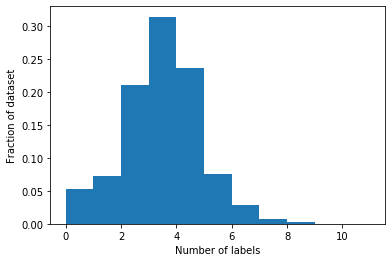

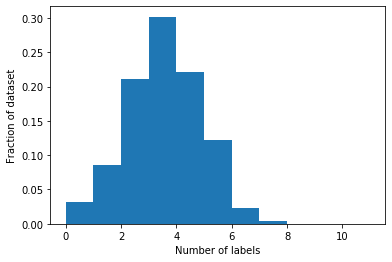

In [411]:
from matplotlib import pyplot as plt


def plot_label_frequency(L):
    plt.hist(
        (L != ABSTAIN).sum(axis=1),
        density=True,
        bins=range(L.shape[1])
    )
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)
plot_label_frequency(L_dev)

### Interpretation

The overall label coverage looks good. Now we need to look at each label's coverage.

## Analyze the Labeling Functions' Performance

Overall label coverage is good but we need to make sure the distribution of our LF output is approximately even otherwise the label model won't have enough data with which to make good inferences about how LFs relate.

To help with this, we first prepare a `DataFrame` of label function names and their corresponding text labels to add to the `LFAnalysis.lf_summary` output to make it clearer what the coverage is for each label. 

In [412]:
# Prepare a name/label DataFrame to join to the LF Summary DataFrame below
lf_names = [lf.name for lf in lfs]
lf_labels = [lf._resources['label'] for lf in lfs]
lf_label_names = [{'Labels': number_to_name_dict[l]} for l in lf_labels]
label_name_df = pd.DataFrame(lf_label_names, index=lf_names)

label_name_df

,Labels
keyword_sdk_field_full_name,API
keyword_api_field_full_name,API
keyword_walkthrough_walk through_field_full_name_description_readme,API
keyword_skill_skills_field_full_name_description_readme,API
keyword_kit_kits_field_description_readme,API
keyword_extension_field_description_readme,API
keyword_amazon_field_description_readme,API
keyword_aws_field_full_name_description,API
keyword_integrate_integration_field_full_name_description_readme,API
keyword_/ion_field_full_name,GENERAL


### Run our `LFAnalysis` with Labels

Now we can run the LFAnalysis, get the summary and join our label names to see a clear indication of how well we're covering each label.

In [413]:
from snorkel.labeling import LFAnalysis

# Run the LF analysis on the gold labeled data
dev_lfa = LFAnalysis(L=L_dev, lfs=lfs)
dev_lfa_df = dev_lfa.lf_summary(Y=dev_labels.values)
dev_lfa_df['name'] = dev_lfa_df.index

# Join the label names in because the 'Polarity' field is confusing
lfa_label_df = dev_lfa_df.join(label_name_df)
lfa_label_df

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,name,Labels
keyword_sdk_field_full_name,0,[1],0.058559,0.058559,0.000000,12,1,0.923077,keyword_sdk_field_full_name,API
keyword_api_field_full_name,1,[1],0.009009,0.009009,0.000000,2,0,1.000000,keyword_api_field_full_name,API
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.054054,0.054054,0.000000,12,0,1.000000,keyword_walkthrough_walk through_field_full_name_description_readme,API
keyword_skill_skills_field_full_name_description_readme,3,[1],0.058559,0.058559,0.000000,13,0,1.000000,keyword_skill_skills_field_full_name_description_readme,API
keyword_kit_kits_field_description_readme,4,[1],0.126126,0.121622,0.000000,27,1,0.964286,keyword_kit_kits_field_description_readme,API
keyword_extension_field_description_readme,5,[1],0.081081,0.081081,0.000000,13,5,0.722222,keyword_extension_field_description_readme,API
keyword_amazon_field_description_readme,6,[1],0.788288,0.774775,0.004505,164,11,0.937143,keyword_amazon_field_description_readme,API
keyword_aws_field_full_name_description,7,[1],0.815315,0.761261,0.000000,176,5,0.972376,keyword_aws_field_full_name_description,API
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193694,0.189189,0.004505,40,3,0.930233,keyword_integrate_integration_field_full_name_description_readme,API
keyword_/ion_field_full_name,9,[0],0.009009,0.004505,0.004505,2,0,1.000000,keyword_/ion_field_full_name,GENERAL


## Determine Coverage by Label

Now we can group by the label and determine the raw count correct, incorrect and total. This will give us an idea of coverage per label.

In [414]:
g_lf_df = lfa_label_df.groupby('Labels').agg({'Correct': 'sum', 'Incorrect': 'sum'})
g_lf_df['Total LFs'] = g_lf_df['Correct'] + g_lf_df['Incorrect']
sum_total_lf = g_lf_df['Total LFs'].sum()
g_lf_df['Total LF Ratio'] = g_lf_df['Total LFs'] / sum_total_lf
g_lf_df['Total Correct Ratio'] = g_lf_df['Correct'] / sum_total_lf

g_lf_df

,Correct,Incorrect,Total LFs,Total LF Ratio,Total Correct Ratio
Labels,,,,,
API,641,39,680,0.997067,0.939883
GENERAL,2,0,2,0.002933,0.002933


## Compare to Gold Label Coverage

We need to compare this LF coverage to the raw gold label coverage, which will give us an idea of the disparity between the two.

In [415]:
dev_g_df = dev_df.groupby('label').agg({'full_name': 'count'})
dev_g_df

sum_total_labels = dev_g_df['full_name'].sum()
dev_g_df['Total Hand Label Ratio'] = dev_g_df['full_name'] / sum_total_labels
dev_g_df.columns = ['Total Labels', 'Total Hand Label Ratio']

dev_g_df

,Total Labels,Total Hand Label Ratio
label,,
API,198,0.891892
GENERAL,24,0.108108


In [416]:
combined_df = dev_g_df.join(g_lf_df)
combined_df

combined_df['LF / Label Ratio'] = combined_df['Total LF Ratio'] / combined_df['Total Hand Label Ratio']
combined_df['Correct LF / Label Ratio'] = combined_df['Total Correct Ratio'] / combined_df['Total Hand Label Ratio']

combined_df

,Total Labels,Total Hand Label Ratio,Correct,Incorrect,Total LFs,Total LF Ratio,Total Correct Ratio,LF / Label Ratio,Correct LF / Label Ratio
label,,,,,,,,,
API,198,0.891892,641,39,680,0.997067,0.939883,1.117924,1.053808
GENERAL,24,0.108108,2,0,2,0.002933,0.002933,0.027126,0.027126


### Interpretation

It looks like we are way over-covering `API` and way under covering `GENERAL`. Let's fix that!

## Determine Standout Tokens Per Class

Inspect the top 5 tokens in terms of TF-IDF per record then look for standouts per class.

In [417]:
from sklearn.feature_extraction.text import TfidfVectorizer


v = TfidfVectorizer()
m = v.fit_transform(dev_df['readme'])
index_to_word = dict([(value, key) for key, value in v.vocabulary_.items()])

term_rows = []
for row in m.toarray():
    words = []
    for i, val in enumerate(row):
        if val > 0:
            words.append((
                val,
                index_to_word[i]
            ))
    term_rows.append(
        [y[1] for y in sorted(words, key=lambda x: x[0], reverse=True)[0:5]]
    )

dev_df['top_terms'] = term_rows
df_short = dev_df[['full_name', 'description', 'label', 'top_terms', 'readme']]
api_df = df_short[df_short['label'] == 'GENERAL']

# See the READMEs
pd.set_option('display.max_colwidth', 300)
api_df = api_df[['full_name', 'description', 'label', 'top_terms', 'readme']]

api_df

,full_name,description,label,top_terms,readme
id,,,,,
21922866,twitchscience/scoop_protocol,The communication protocol for services to perform actions on redshift,GENERAL,"[cross, handler, lib, account, js]",# aws-cross-account-manager\n\nSource code for the AWS solution [Cross Account Manager](https://aws.amazon.com/answers/account-management/aws-multi-account-security-strategy/).\n\n## CloudFormation templates\n\n- aws-cross-account-manager-master.template\n- aws-cross-account-manager-sub.template...
168736353,opendistro-for-elasticsearch/security-advanced-modules,Advanced modules for the Open Distro for Elasticsearch security plugin,GENERAL,[],
142940518,awslabs/aws-c-http,C99 implementation of the HTTP/1.1 and HTTP/2 specifications,GENERAL,"[ingress, apigateway, kubernetes, controller, nginx]",# Amazon API Gateway Ingress Controller\n\n## Getting Started\n\nThe default configuration assumes you are using kube2iam to manage pod permissions.\nTo set up a role for this controller use the following command\n\n```sh\nexport INSTANCE_ROLE_ARNS=`comma delimited list of k8s worker instance AR...
34824356,c9/c9.ide.processlist,"The repository for c9.ide.processlist, a Cloud9 core plugin",GENERAL,"[tts, ros, polly, the, speak]","# tts\n\n\n## Overview\nThe `tts` ROS node enables a robot to speak with a human voice by providing a Text-To-Speech service.\nOut of the box this package listens to a speech topic, submits text to the Amazon Polly cloud service to generate an audio stream file,\nretrieves the audio stream from ..."
43976345,amzn/ion-tests,Test vectors for testing compliant Ion implementations.,GENERAL,"[enip, cip, zeek, phy, scy]",## Zeek Plugin ENIP\n\nWhen running as part of your Zeek installation this plugin will produce three log files containing metadata extracted from any Ethernet/IP (ENIP) and Common Industrial Protocol (CIP) traffic observed on UDP port 2222 and port 44818 TCP/UDP. Ethernet/IP and CIP are often ob...
154743353,aws-robotics/utils-ros1,ROS packages for facilitating the use of AWS cloud services.,GENERAL,"[carbonado, carbonadotestsuite, suite, contains, test]",CarbonadoTestSuite\n=====================\n\nThis package contains the test suite for [Carbonado](http://github.com/Carbonado/Carbonado).\n
1028340,ajaxorg/ace,Ace (Ajax.org Cloud9 Editor),GENERAL,"[rig, developer, twitch, the, https]","# Native Developer Rig 1.0 is Now Available\nIf you're looking to use the Developer Rig to work on your extensions, please download the Native Developer Rig.\n\nWe support [Mac](https://developer-rig.twitchcdn.net/Twitch%20Developer%20Rig.dmg), [Windows](https://developer-rig.twitchcdn.net/Twitc..."
217150169,awslabs/tough,Rust libraries and tools for using and generating TUF repositories,GENERAL,"[dx, monitor, the, pending, deleted]",# aws-dx-monitor\n\nThe purpose of ***aws-dx-monitor*** is enabling customers to monitor [AWS Direct Connect](https://aws.amazon.com/directconnect/) runtime configuration items with [Amazon CloudWatch](https://aws.amazon.com/cloudwatch/). The system is driven by [Amazon CloudWatch Events](http:...
14907266,Carbonado/CarbonadoSleepycatDB,"CarbonadoSleepycatDB contains a repository supporting Sleepycat/Oracle, Berkeley DB.",GENERAL,"[kinsumer, shards, kinesis, twitchscience, go]",# Kinsumer\n\nNative Go consumer for AWS Kinesis streams.\n\n[![Build Status](https://travis-ci.org/twitchscience/kinsumer.svg?branch=master)](https://travis-ci.org/TwitchScience/kinsumer) [![Go Report Card](https://goreportcard.com/badge/github.com/twitchscience/kinsumer)](https://goreportcard....


## New LFs for API

We need some new LFs for API, so lets look at common n-grams of consequence for that class.

In [419]:
# Cloud9 is a GENERAL purpose project
cloud9_lf = make_keyword_lf(
    keywords=['cloud9', 'c9'],
    field=['full_name', 'description'],
    label=GENERAL,
)

# Open Distro is GENERAL
open_distro_lf = make_keyword_lf(
    keywords=['opendistro','open distro'],
    field=['full_name', 'description', 'readme'],
    label=GENERAL,
)

library_lf = make_keyword_lf(
    keywords=['library for'],
    field=['description'],
    label=GENERAL,
)

git_lf = make_keyword_lf(
    keywords=['protocol'],
    field=['full_name', 'description'],
    label=GENERAL,
)

# Add the LFs to one large list
lfs = [
    sdk_lf,
    api_lf,
    walkthrough_lf,
    skill_lf,
    kit_lf,
    extension_lf,
    amazon_lf,
    aws_lf,
    integration_lf,
    ion_lf,
    sample_lf,
    demo_lf,
    cloud9_lf,
    open_distro_lf,
    library_lf,
    git_lf,
]
lfs

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 414/414 [00:00<00:00, 1042.50it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.058559,0.058559,0.000000,12,1,0.923077
keyword_api_field_full_name,1,[1],0.009009,0.009009,0.000000,2,0,1.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.054054,0.054054,0.000000,12,0,1.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.058559,0.058559,0.000000,13,0,1.000000
keyword_kit_kits_field_description_readme,4,[1],0.126126,0.126126,0.004505,27,1,0.964286
keyword_extension_field_description_readme,5,[1],0.081081,0.081081,0.009009,13,5,0.722222
keyword_amazon_field_description_readme,6,[1],0.788288,0.774775,0.031532,164,11,0.937143
keyword_aws_field_full_name_description,7,[1],0.815315,0.765766,0.018018,176,5,0.972376
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193694,0.193694,0.009009,40,3,0.930233
keyword_/ion_field_full_name,9,[0],0.009009,0.004505,0.004505,2,0,1.000000


In [384]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,[1],0.076233,0.076233,0.000000
keyword_api_field_full_name,1,[1],0.017937,0.017937,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.044843,0.044843,0.002242
keyword_skill_skills_field_full_name_description_readme,3,[1],0.071749,0.069507,0.000000
keyword_kit_kits_field_description_readme,4,[1],0.145740,0.143498,0.004484
keyword_extension_field_description_readme,5,[1],0.071749,0.071749,0.004484
keyword_amazon_field_description_readme,6,[1],0.773543,0.760090,0.033632
keyword_aws_field_full_name_description,7,[1],0.843049,0.804933,0.024664
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.181614,0.181614,0.008969
keyword_/ion_field_full_name,9,[0],0.008969,0.008969,0.008969
